## 1. Business Understanding

This project will analyze customer reviews of Amazon's electronic products to identify the key drivers of customer satisfaction and dissatisfaction. By understanding what customers love and hate about our products, we can provide actionable insights to:

*   **Product Development:** Pinpoint specific features that need improvement and identify new features that customers desire.
*   **Marketing:** Craft more effective marketing messages that highlight the features customers love the most.
*   **Quality Assurance:** Identify products with recurring quality issues.

The ultimate goal is to improve product quality, increase customer satisfaction, and boost sales.

## 2. Data Understanding

I chose to use [Consumer Reviews of Amazon Products](https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products) from Kaggle because it contains a lot of the review from the customers. It also contain some important featues, such as categories of the product, manufaturer of the product and the rating, which is really helpful for sentiment analytics and further exploration. Unfortunately, after exaim this dataset, it only contains review which related to technical product, and only include the product manufacture by Amazon, I think it'll be the biggest hindrance when using this dataset for analyze

In [72]:
import kagglehub
import pandas as pd
import os
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")
    

In [73]:
df1 = pd.read_csv(os.path.join(path, '1429_1.csv'), low_memory=False)
df2 = pd.read_csv(os.path.join(path, 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'))
df3 = pd.read_csv(os.path.join(path, 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'))

The original dataset from Kaggle be divided to three sperate csv file, after concate it, it include the following features and information. Here is a quick overview:

In [74]:
master_df = pd.concat([df1, df2, df3], ignore_index=True)
master_df.to_csv('amazon_reviews_master.csv')
master_df.info()
master_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    67992 non-null  object 
 1   name                  61232 non-null  object 
 2   asins                 67990 non-null  object 
 3   brand                 67992 non-null  object 
 4   categories            67992 non-null  object 
 5   keys                  67992 non-null  object 
 6   manufacturer          67992 non-null  object 
 7   reviews.date          67953 non-null  object 
 8   reviews.dateAdded     25091 non-null  object 
 9   reviews.dateSeen      67992 non-null  object 
 10  reviews.didPurchase   10 non-null     object 
 11  reviews.doRecommend   55152 non-null  object 
 12  reviews.id            71 non-null     float64
 13  reviews.numHelpful    55246 non-null  float64
 14  reviews.rating        67959 non-null  float64
 15  reviews.sourceURLs 

id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       42901
reviews.dateSeen            0
reviews.didPurchase     67982
reviews.doRecommend     12840
reviews.id              67921
reviews.numHelpful      12746
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title              19
reviews.userCity        67992
reviews.userProvince    67992
reviews.username           13
dateAdded               34660
dateUpdated             34660
primaryCategories       34660
imageURLs               34660
manufacturerNumber      34660
sourceURLs              34660
dtype: int64

We can see all the columns and their missing values in the result above

### 3. Data Preparation & Exploratory Data Analysis (EDA)

In [75]:
master_df.isna().sum()
master_df.duplicated().sum()

np.int64(95)

#### - Drop unrelated features and duplicate values

In [76]:
df_cleaned = master_df.copy()

In [77]:
df_cleaned.drop_duplicates(subset=['reviews.username', 'reviews.text', 'reviews.rating'], inplace=True)

In [78]:
# Define the columns to drop
columns_to_drop = [
    'reviews.userCity',
    'reviews.userProvince',
    'reviews.id',
    'reviews.didPurchase',
    'reviews.dateAdded',
    'id',
    'asins',
    'keys',
    'manufacturer',
    'reviews.sourceURLs',
    'sourceURLs',
    'imageURLs',
    'manufacturerNumber',
    'dateAdded',
    'dateUpdated'
]

df_cleaned.drop(columns=columns_to_drop, inplace=True)

#### - Drop missing value & chage the data type

In [79]:
# Drop rows where essential data is missing
df_cleaned.dropna(subset=['reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username', 'reviews.date', 'reviews.doRecommend'], inplace=True)
df_cleaned['primaryCategories'] = df_cleaned['primaryCategories'].fillna('Unknown')
df_cleaned['name'] = df_cleaned['name'].fillna('Unknown')
df_cleaned['reviews.date'] = pd.to_datetime(df_cleaned['reviews.date'], errors='coerce')
df_cleaned['reviews.rating'] = df_cleaned['reviews.rating'].astype(int)
df_cleaned['reviews.numHelpful'] = df_cleaned['reviews.numHelpful'].fillna(0).astype(int)


df_cleaned.info()
df_cleaned.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 37297 entries, 0 to 66412
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   name                 37297 non-null  object             
 1   brand                37297 non-null  object             
 2   categories           37297 non-null  object             
 3   reviews.date         37297 non-null  datetime64[ns, UTC]
 4   reviews.dateSeen     37297 non-null  object             
 5   reviews.doRecommend  37297 non-null  object             
 6   reviews.numHelpful   37297 non-null  int64              
 7   reviews.rating       37297 non-null  int64              
 8   reviews.text         37297 non-null  object             
 9   reviews.title        37297 non-null  object             
 10  reviews.username     37297 non-null  object             
 11  primaryCategories    37297 non-null  object             
dtypes: datetime64[ns, UTC](

name                   0
brand                  0
categories             0
reviews.date           0
reviews.dateSeen       0
reviews.doRecommend    0
reviews.numHelpful     0
reviews.rating         0
reviews.text           0
reviews.title          0
reviews.username       0
primaryCategories      0
dtype: int64

#### - Review text Cleaning for sentiment analyze

In [80]:
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

df_cleaned['reviews.text_cleaned'] = df_cleaned['reviews.text'].apply(clean_text)
df_cleaned['reviews.title_cleaned'] = df_cleaned['reviews.title'].apply(clean_text)

#### - Fig1. Distribution of Customer Ratings

In [81]:
import plotly.graph_objects as go
from collections import Counter

rating_counts = Counter(df_cleaned['reviews.rating'])
ratings = sorted(rating_counts.keys())
counts = [rating_counts[rating] for rating in ratings]

fig1 = go.Figure(data=[go.Bar(x=ratings, y=counts)])

fig1.update_layout(
    title='Distribution of Customer Ratings',
    xaxis_title='Rating',
    yaxis_title='Number of Reviews',
    xaxis=dict(tickmode='linear')
)

fig1.show()

- The first chart shows that almost everyone loves these products. The bar for 5-star reviews is huge (over 25,000!), way more than all the other ratings combined.

- This shows that, in general, customers are super happy. But it also means I should probably pay extra attention to the few 1-star and 2-star reviews, since they're so different from the norm.

#### Fig2. Average Customer Rating Over Time

In [82]:
df_cleaned['reviews.date'] = pd.to_datetime(df_cleaned['reviews.date'])

df_cleaned['month_year'] = df_cleaned['reviews.date'].dt.tz_localize(None).dt.to_period('M')
monthly_ratings = df_cleaned.groupby('month_year')['reviews.rating'].mean().reset_index()
monthly_ratings = monthly_ratings.sort_values('month_year')

monthly_ratings['month_year'] = monthly_ratings['month_year'].dt.to_timestamp()

fig2 = go.Figure(data=[go.Scatter(x=monthly_ratings['month_year'], y=monthly_ratings['reviews.rating'], mode='lines+markers')])

fig2.update_layout(
    title='Average Customer Rating Over Time',
    xaxis_title='Date',
    yaxis_title='Average Rating'
)

fig2.show()

- Overall, average customer ratings remain high, consistently staying above 4.3 stars. This reinforces our finding that most customers are highly satisfied.

- There was a severe drop in customer satisfaction in the second half of 2015, with average ratings plummeting from 4.8 to below 4.4. This is a major red flag. This trend reversed in early 2016, followed by a slow, steady 2-year recovery.

- We see a massive spike in satisfaction in mid-2018, with ratings hitting a perfect 5.0 before becoming more volatile. This spike likely corresponds to a very successful new product launch.

#### Fig3. WordClound of Reviews

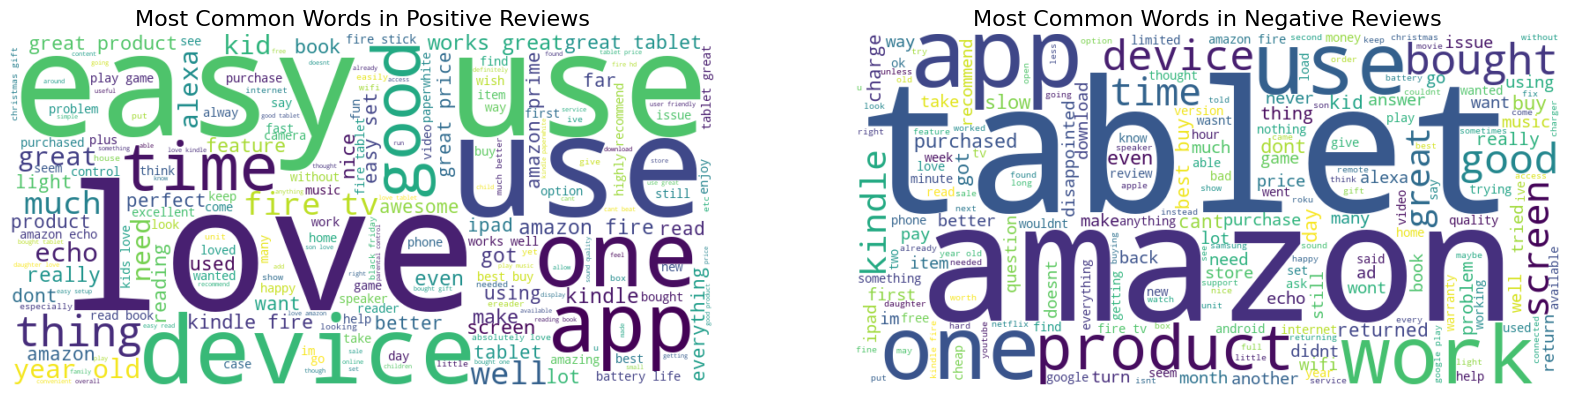

In [83]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_reviews = df_cleaned[df_cleaned['reviews.rating'].isin([4, 5])]['reviews.text_cleaned']
negative_reviews = df_cleaned[df_cleaned['reviews.rating'].isin([1, 2])]['reviews.text_cleaned']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

wordcloud_positive = WordCloud(width=800, height=400, background_color='white'
).generate(positive_text)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white'
).generate(negative_text)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews', fontsize=16)
plt.axis('off')

plt.show()

- In Positive Reviews: The biggest words are love, easy, use, and device.

- In Negative Reviews: The word tablet is massive. Other big words are app, problem, and work.

- It looks like people are happiest when the product is just easy to use. The negative reviews suggest that the tablets are the main source of problems, probably related to apps not working right or the device itself breaking.

#### Fig4. Average "Helpful" Votes by Star Rating

In [84]:
helpfulness_by_rating = df_cleaned.groupby('reviews.rating')['reviews.numHelpful'].mean().reset_index()

fig4 = go.Figure(data=[
    go.Bar(
        x=helpfulness_by_rating['reviews.rating'],
        y=helpfulness_by_rating['reviews.numHelpful']
    )
])

fig4.update_layout(
    title='Average "Helpful" Votes by Star Rating',
    xaxis_title='Star Rating',
    yaxis_title='Average "Helpful" Votes'
)

fig4.show()

- This chart was really surprising. 1-star reviews get an average of 1.75 "helpful" votes, which is way more than any other rating. 2-star reviews are the second most helpful.

- This shows that people actually find the negative reviews more helpful when they're deciding what to buy. It's a big deal because it means the company should really be reading and replying to those 1-star reviews.

#### Fig5. Review Length vs. Star Rating

In [85]:
df_cleaned['review_length'] = df_cleaned['reviews.text'].str.len()

fig5 = go.Figure(data=[
    go.Box(
        x=df_cleaned['reviews.rating'],
        y=df_cleaned['review_length']
    )
])

# 3. Manually set the titles and labels
fig5.update_layout(
    title='Review Length vs. Star Rating',
    xaxis_title='Star Rating',
    yaxis_title='Length of Review (Characters)'
)

# 4. Your y-axis update is the same
fig5.update_yaxes(range=[0, 2000])

fig5.show()

- I made a boxplot to see if angry people write more, and they do. The "box" for 1-star and 2-star reviews is higher up, meaning their typical review length is longer than for 3, 4, or 5-star reviews.

- Those dots are outliers (some people write a lot), but the main takeaway is that negative reviews are usually more detailed. People aren't just saying "it's bad"; they're explaining why it's bad, which is really useful data for the company to find and fix bugs.

## 4. Modeling

In [ ]:
# Create a new dataframe for modeling, dropping the 3-star reviews (too less of data)
df_model = df_cleaned[df_cleaned['reviews.rating'] != 3].copy()

df_model['sentiment'] = df_model['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

print(df_model['sentiment'].value_counts())

sentiment
1    34911
0      799
Name: count, dtype: int64


In [87]:
X = df_model['reviews.text_cleaned']
y = df_model['sentiment']

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [90]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)

lr_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [91]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## 5. Evaluation

--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.21      0.70      0.33       160
           1       0.99      0.94      0.97      6982

    accuracy                           0.94      7142
   macro avg       0.60      0.82      0.65      7142
weighted avg       0.98      0.94      0.95      7142



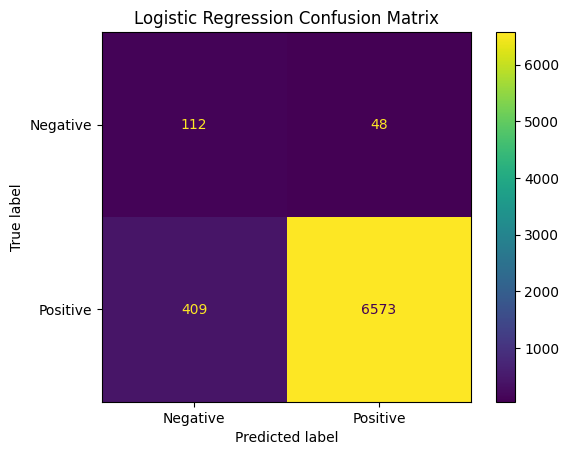


--- Naive Bayes Report ---
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       160
           1       0.98      1.00      0.99      6982

    accuracy                           0.98      7142
   macro avg       0.99      0.50      0.50      7142
weighted avg       0.98      0.98      0.97      7142



In [92]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Evaluate the Baseline (Logistic Regression) ---
y_pred_lr = lr_model.predict(X_test_tfidf)

print("--- Logistic Regression Report ---")
# Pay close attention to the 'precision' and 'recall' for class 0 (negative)
print(classification_report(y_test, y_pred_lr)) 

# Display the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Negative', 'Positive'])
disp_lr.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# --- Repeat for your Improved Model (Naive Bayes) ---
y_pred_nb = nb_model.predict(X_test_tfidf)

print("\n--- Naive Bayes Report ---")
print(classification_report(y_test, y_pred_nb))
# ... (and make a confusion matrix for it, too)

In [93]:
# Get feature names from your vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients from the LR model
coefficients = lr_model.coef_[0]

# Create a DataFrame of words and their scores
coef_df = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})

# Get top 15 POSITIVE drivers
print("Top Positive Drivers:")
print(coef_df.sort_values('coefficient', ascending=False).head(15))

# Get top 15 NEGATIVE drivers
print("\nTop Negative Drivers:")
print(coef_df.sort_values('coefficient', ascending=True).head(15))

Top Positive Drivers:
           word  coefficient
1899      great     6.661778
1287       easy     5.024162
1452  excellent     4.879885
2616       love     4.242998
2621      loves     3.884927
389        beat     3.845978
4625         tv     3.817005
1541       fast     3.618636
2561     little     3.579729
152     amazing     3.568944
4226      stick     3.393227
1534     family     3.197530
2855      music     3.139584
1294       echo     3.121402
1540        far     3.115511

Top Negative Drivers:
               word  coefficient
3714       returned    -8.025999
4049           slow    -6.756110
3713         return    -6.659992
1152   disappointed    -6.002449
1612            fir    -5.848151
3715      returning    -5.818954
2728           meet    -5.612529
3201       pictures    -5.502667
4437       terrible    -5.183522
610          cannot    -4.876683
348            back    -4.809675
2323            iti    -4.534917
12    accessibility    -4.465978
4728        useless    -4.459

## 6. Summary